<a href="https://colab.research.google.com/github/ranpei97/E4511-2021-Pei/blob/main/HTR2A_EDA_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Install packages

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-04-08 01:21:52--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   236MB/s    in 2.1s    

2021-04-08 01:21:54 (236 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


InvalidVersionSpec: Invalid version '4.19.112+': empty version component


real	0m8.252s
user	0m6.092s
sys	0m1.281s
--2021-04-08 01:28:16--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.07K

In [2]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io

In [5]:
!pip install molvs
!pip install bravado
!pip install umap

     |████████████████████████████████| 71kB 13.8MB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=f6c829dac45e1c8e86f988fcdbc86351416d3c3d82f69596d47cbbd1bb419053
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built molvs


In [6]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

In [7]:
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_Excape.csv
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_ChEMBL.csv
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_DTC.csv

--2021-04-08 01:59:19--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_Excape.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360705 (352K) [text/plain]
Saving to: ‘HTR2A_Excape.csv’

HTR2A_Excape.csv    100%[===================>] 352.25K  --.-KB/s    in 0.02s   

2021-04-08 01:59:19 (18.5 MB/s) - ‘HTR2A_Excape.csv’ saved [360705/360705]

--2021-04-08 01:59:19--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_ChEMBL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1133615 (1.1M) 

In [8]:
dtc = pd.read_csv("HTR2A_DTC.csv", sep=',', header=0 )
excape = pd.read_csv("HTR2A_Excape.csv",sep=',', header=0)
chembl = pd.read_csv("HTR2A_ChEMBL.csv", sep=';', header=0)

In [9]:
dtc.iloc[1:3,1:10]

,Uniprot ID,Compound Name,Standard inchi key,Max Phase,Target Pref Name,Gene Names,Target Class,Wild type or mutant,Mutation information
1,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN
2,P28223,NaN,WDJQOCMHRCDUPP-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN


In [10]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,CHEMBL2331795,3356,N,3.50000,chembl20,946115,9606,HTR2A,2099,C1CC2=C(CCN1C)ON=C2OC
2,9813197,3356,A,7.03152,pubchem,326603,9606,HTR2A,2099,ClC=1C=2CCNCCC2C=CC1Cl


In [11]:
chembl.iloc[1:3, 1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0,425.60,0,3.98,3q,O=C1C2CCCCC2C(=O)N1CCCCN1CCN(c2cccc3sccc23)CC1,IC50,'='
2,NaN,0,448.44,0,4.52,"2, TG6-10-1",COc1cc(/C=C/C(=O)NCCn2c(C(F)(F)F)cc3ccccc32)cc...,IC50,'='


# Examine data
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [12]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(1866, 45)
(9469, 43)
(2605, 11)


In [13]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4285839,NaN,0,437.54,0,2.17,3h,O=C1[C@H]2[C@@H]3C=C[C@@H](C3)[C@H]2C(=O)N1CCC...,IC50,'=',854.0,nM,6.07,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
1,CHEMBL4283546,NaN,0,425.60,0,3.98,3q,O=C1C2CCCCC2C(=O)N1CCCCN1CCN(c2cccc3sccc23)CC1,IC50,'=',34.0,nM,7.47,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
2,CHEMBL3264204,NaN,0,448.44,0,4.52,"2, TG6-10-1",COc1cc(/C=C/C(=O)NCCn2c(C(F)(F)F)cc3ccccc32)cc...,IC50,'=',75000.0,nM,4.12,NaN,NaN,UO_0000065,9.20,0.18,-0.40,6.68,False,CHEMBL3293197,Inhibition of 5HT2A receptor (unknown origin),B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3286257,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,None,NaN
3,CHEMBL4294797,NaN,0,419.55,0,4.10,8a,O=C1c2ccccc2C(=O)N1CCCCN1CCN(c2cccc3sccc23)CC1,IC50,'=',683.0,nM,6.17,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
4,CHEMBL51,KETANSERIN,4,395.43,0,2.42,Ketanserin,O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=...,IC50,'=',0.9,nM,9.05,NaN,NaN,UO_0000065,22.88,0.43,6.63,12.03,False,CHEMBL2394909,Binding affinity to human 5-HT2A receptor by r...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL2390830,1,Scientific Literature,Eur. J. Med. Chem.,2013.0,None,NaN


In [14]:
chembl.Standard_Type.value_counts()

IC50    1866
Name: Standard_Type, dtype: int64

## Exercise: Explore datasets
- explore the loaded dtc and excape dataframes
- answer the following questions

## Questions

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [15]:
# You code goes in here and the following chunks

In [16]:
dtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9469 entries, 0 to 9468
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Compound_ID                         9392 non-null   object 
 1   Uniprot_ID                          9469 non-null   object 
 2   Compound_Name                       3085 non-null   object 
 3   Standard_inchi_key                  9145 non-null   object 
 4   Max_Phase                           9469 non-null   int64  
 5   Target_Pref_Name                    9469 non-null   object 
 6   Gene_Names                          9469 non-null   object 
 7   Target_Class                        9469 non-null   object 
 8   Wild_type_or_mutant                 0 non-null      float64
 9   Mutation_information                0 non-null      float64
 10  PubMed_ID                           6577 non-null   float64
 11  End_Point_Standard_Type             9469 no

In [17]:
excape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ambit_InchiKey     2605 non-null   object 
 1   Original_Entry_ID  2605 non-null   object 
 2   Entrez_ID          2605 non-null   int64  
 3   Activity_Flag      2605 non-null   object 
 4   pXC50              2559 non-null   float64
 5   DB                 2605 non-null   object 
 6   Original_Assay_ID  2605 non-null   int64  
 7   Tax_ID             2605 non-null   int64  
 8   Gene_Symbol        2605 non-null   object 
 9   Ortholog_Group     2605 non-null   int64  
 10  SMILES             2605 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 224.0+ KB


In [18]:
chembl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule_ChEMBL_ID          1866 non-null   object 
 1   Molecule_Name               889 non-null    object 
 2   Molecule_Max_Phase          1866 non-null   int64  
 3   Molecular_Weight            1866 non-null   object 
 4   #RO5_Violations             1866 non-null   object 
 5   AlogP                       1866 non-null   object 
 6   Compound_Key                1866 non-null   object 
 7   Smiles                      1834 non-null   object 
 8   Standard_Type               1866 non-null   object 
 9   Standard_Relation           1084 non-null   object 
 10  Standard_Value              1084 non-null   float64
 11  Standard_Units              1084 non-null   object 
 12  pChEMBL_Value               986 non-null    float64
 13  Data_Validity_Comment       1 non

In [19]:
# pIC50 = -log_10(IC50)

In [20]:
chembl.Standard_Units.unique()

array(['nM', nan], dtype=object)

# EDA: assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [21]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4285839,NaN,0,437.54,0,2.17,3h,O=C1[C@H]2[C@@H]3C=C[C@@H](C3)[C@H]2C(=O)N1CCC...,IC50,'=',854.0,nM,6.07,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
1,CHEMBL4283546,NaN,0,425.60,0,3.98,3q,O=C1C2CCCCC2C(=O)N1CCCCN1CCN(c2cccc3sccc23)CC1,IC50,'=',34.0,nM,7.47,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
2,CHEMBL3264204,NaN,0,448.44,0,4.52,"2, TG6-10-1",COc1cc(/C=C/C(=O)NCCn2c(C(F)(F)F)cc3ccccc32)cc...,IC50,'=',75000.0,nM,4.12,NaN,NaN,UO_0000065,9.20,0.18,-0.40,6.68,False,CHEMBL3293197,Inhibition of 5HT2A receptor (unknown origin),B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3286257,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,None,NaN
3,CHEMBL4294797,NaN,0,419.55,0,4.10,8a,O=C1c2ccccc2C(=O)N1CCCCN1CCN(c2cccc3sccc23)CC1,IC50,'=',683.0,nM,6.17,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4254803,Antagonist activity at 5-HT2A receptor (unknow...,F,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4251643,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
4,CHEMBL51,KETANSERIN,4,395.43,0,2.42,Ketanserin,O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=...,IC50,'=',0.9,nM,9.05,NaN,NaN,UO_0000065,22.88,0.43,6.63,12.03,False,CHEMBL2394909,Binding affinity to human 5-HT2A receptor by r...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL2390830,1,Scientific Literature,Eur. J. Med. Chem.,2013.0,None,NaN


In [22]:
chembl.Standard_Units.unique()

array(['nM', nan], dtype=object)

## **Curation step**: change units to be the same for all responses

In [23]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [24]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Source_ID,Document_Year,Properties,Standard_Value_nM
count,1866.000000,1084.000000,986.000000,885.000000,0.0,0.0,0.0,1866.000000,995.000000,0.0,1084.000000
mean,1.505359,1856.503705,6.967089,17.481910,NaN,NaN,NaN,8.982315,2011.035176,NaN,1856.503705
std,1.911226,8072.188768,1.044333,4.793463,NaN,NaN,NaN,8.941047,4.799791,NaN,8072.188768
min,0.000000,0.025000,4.070000,6.060000,NaN,NaN,NaN,1.000000,1995.000000,NaN,0.025000
25%,0.000000,29.000000,6.190000,13.930000,NaN,NaN,NaN,1.000000,2009.000000,NaN,29.000000
50%,0.000000,151.500000,6.980000,15.920000,NaN,NaN,NaN,15.000000,2011.000000,NaN,151.500000
75%,4.000000,1000.000000,7.620000,20.370000,NaN,NaN,NaN,15.000000,2014.000000,NaN,1000.000000
max,4.000000,213796.210000,10.600000,34.110000,NaN,NaN,NaN,38.000000,2019.000000,NaN,213796.210000



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [25]:
chembl=chembl.replace('None',np.nan)

In [26]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

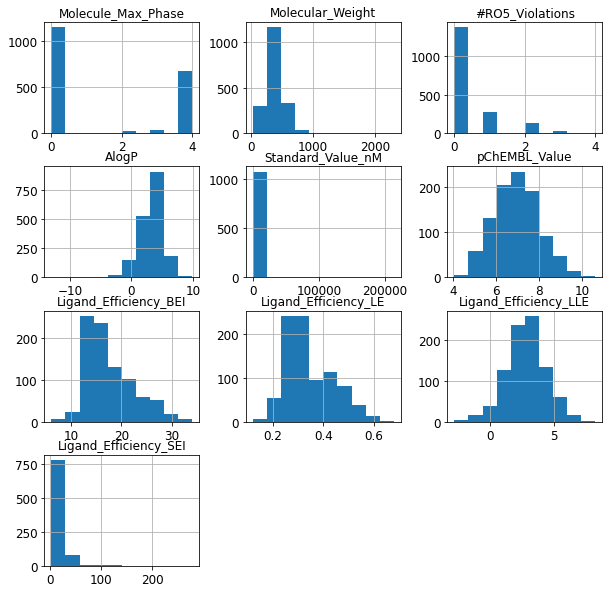

In [27]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,IC50
count,1028.000000
mean,1924.782197
std,8273.939724
min,0.025000
25%,31.000000
50%,171.500000
75%,1000.000000
max,213796.210000


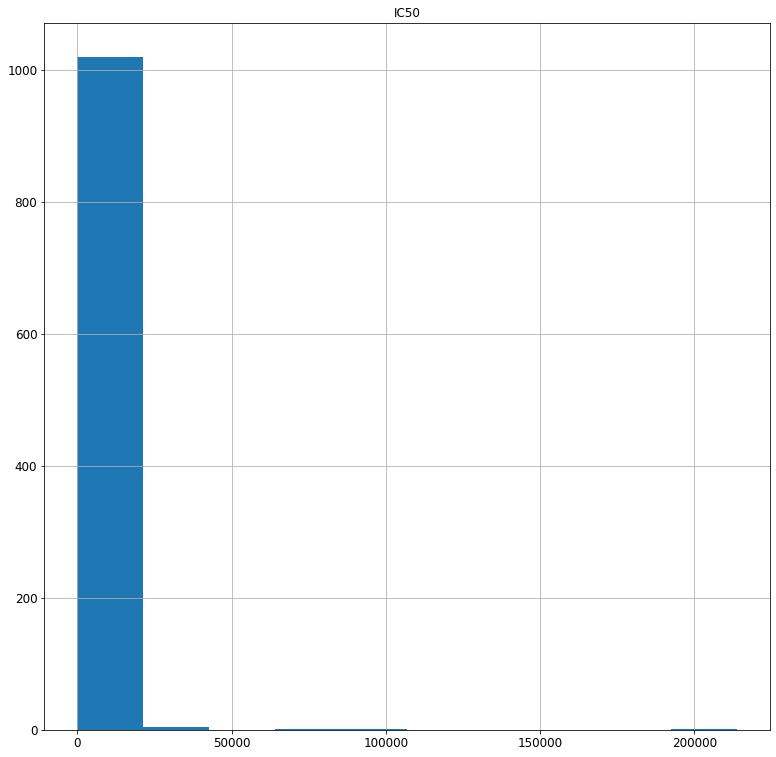

In [28]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,IC50
count,935.000000
mean,6.929930
std,1.030915
min,4.070000
25%,6.170000
50%,6.930000
75%,7.575000
max,10.600000


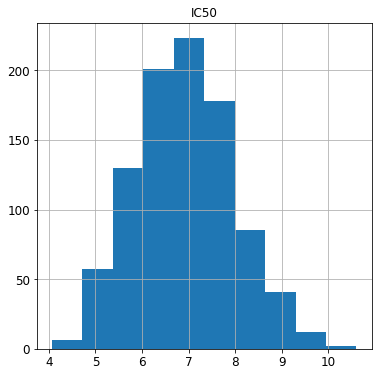

In [29]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [30]:
# try it yourself here

In [31]:
dtc.iloc[0:3, 0:5]

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase
0,CHEMBL10,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0
1,CHEMBL10,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0
2,CHEMBL100264,P28223,NaN,WDJQOCMHRCDUPP-UHFFFAOYSA-N,0


In [32]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7484190,DTCC00132413,2089752,46191
1,CHEMBL10,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7484191,DTCC00132413,2089752,46191
2,CHEMBL100264,P28223,NaN,WDJQOCMHRCDUPP-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,26227779.0,INHIBITION,=,45.27,%,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]ketanserin hydrochloride f...,NaN,Discovery of novel potent and selective ligand...,Bioorg. Med. Chem. Lett.,2015.0,25.0,18.0,"Deng X, Guo L, Xu L, Zhen X, Yu K, Zhao W, Fu W",NaN,1512598.0,DTCT0023186,14523134,DTCC00264342,1389489,63448
3,CHEMBL1006,P28223,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7292521,DTCC00224760,898282,46191
4,CHEMBL1006,P28223,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7292522,DTCC00224760,898282,46191


In [40]:
dtc_ic50 = dtc[dtc.End_Point_Standard_Type == 'IC50']

In [34]:
#from google.colab import files
#dtc_ic50.to_csv(r'dtc_ic50.csv', index=False, header=True)
#files.download('dtc_ic50.csv')

In [41]:
dtc_ic50.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P28223,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7484190,DTCC00132413,2089752,46191
3,CHEMBL1006,P28223,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7292521,DTCC00224760,898282,46191
5,CHEMBL1009,P28223,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7425271,DTCC00224903,1351112,46191
7,CHEMBL101,P28223,PHENYLBUTAZONE,VYMDGNCVAMGZFE-UHFFFAOYSA-N,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7402260,DTCC00142582,217583,46191
12,CHEMBL101168,P28223,1-AMINOBENZOTRIAZOLE,JCXKHYLLVKZPKE-UHFFFAOYSA-N,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7302904,DTCC01742000,2057641,46191


In [42]:
dtc_ic50['pDTC_Value'] = np.where(dtc_ic50.End_Point_Standard_Units == 'NM',-np.log10(dtc_ic50.End_Point_Standard_Value/1000000000 ),dtc_ic50.End_Point_Standard_Value)

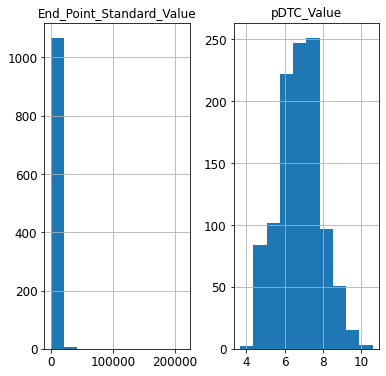

In [45]:
dtc_ic50[['End_Point_Standard_Value','pDTC_Value']].hist(figsize=(6,6));

In [47]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CBAZYOHUXOJCOD-UHFFFAOYNA-N,CHEMBL2331793,3356,A,5.10000,chembl20,946128,9606,HTR2A,2099,C1CC2=C(CCN1)ON=C2OCC
1,CDQYOYMCJUJUGK-UHFFFAOYNA-N,CHEMBL2331795,3356,N,3.50000,chembl20,946115,9606,HTR2A,2099,C1CC2=C(CCN1C)ON=C2OC
2,WMCWIMZEYWNBOQ-UHFFFAOYNA-N,9813197,3356,A,7.03152,pubchem,326603,9606,HTR2A,2099,ClC=1C=2CCNCCC2C=CC1Cl
3,DTNLINZYHBLADN-UHFFFAOYNA-N,CHEMBL2331805,3356,N,3.52000,chembl20,946115,9606,HTR2A,2099,C1CC2C(=CCN1)ON(C2=O)CC
4,IURJRYKQHTZROT-UHFFFAOYNA-N,CHEMBL429689,3356,A,6.89000,chembl20,474629,9606,HTR2A,2099,C1(=CC=C2CCNCCC2=C1Cl)F


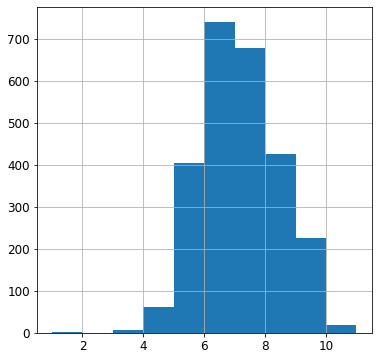

In [48]:
excape['pXC50'].hist(figsize=(6,6));

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt

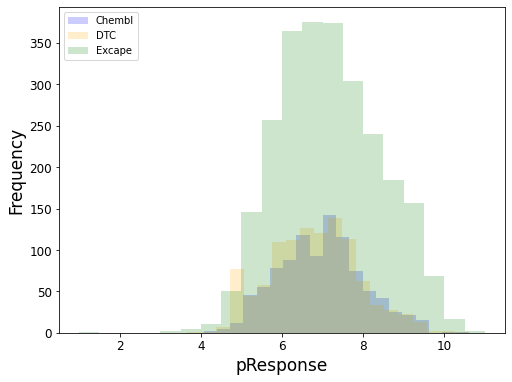

In [50]:
plt.figure(figsize=(8,6))
plt.hist(chembl['pChEMBL_Value'], bins=20, alpha=0.2, label="Chembl", color = 'blue')
plt.hist(dtc_ic50['pDTC_Value'], bins=20, alpha=0.2, label="DTC", color = 'orange')
plt.hist(excape['pXC50'], bins=20, alpha=0.2, label="Excape", color = 'green')
plt.xlabel("pResponse", size=17)
plt.ylabel("Frequency", size=17)
plt.legend(loc='upper left')

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

Neric;
Set a threshold;
IC50

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

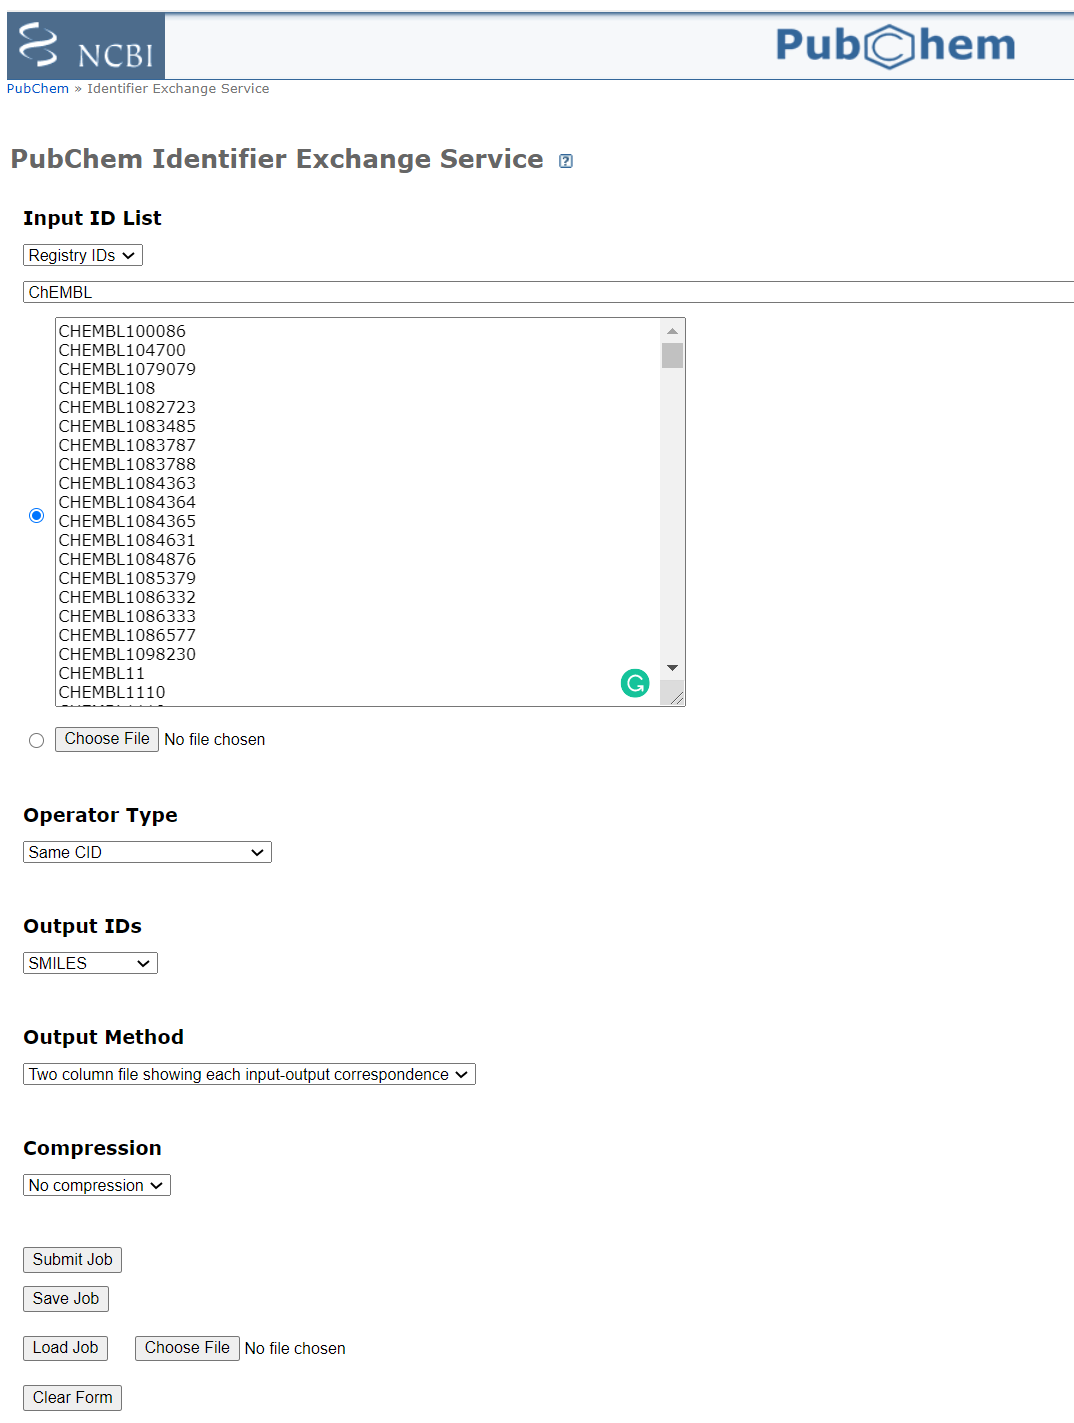

In [46]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

In [51]:
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/dtc_smile.txt

--2021-04-08 02:12:09--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/dtc_smile.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738919 (722K) [text/plain]
Saving to: ‘dtc_smile.txt’

dtc_smile.txt       100%[===================>] 721.60K  --.-KB/s    in 0.04s   

2021-04-08 02:12:10 (18.0 MB/s) - ‘dtc_smile.txt’ saved [738919/738919]



In [52]:
dtc_smiles = pd.read_csv("dtc_smile.txt", sep="\t")

In [53]:
dtc_smiles.head()

,Compound,Unnamed: 1
0,ID,NaN
1,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
3,CHEMBL100264,C1COCCN1C2=NC3=CC=CC=C3C(=N2)NC4=CC=C(C=C4)Cl
4,CHEMBL1006,C(CN)CNCCSP(=O)(O)O


In [54]:
# some data processing
dtc_smiles = dtc_smiles.iloc[1:]
dtc_smiles = dtc_smiles.rename(columns={"Compound": "ChEMBL_ID", "Unnamed: 1": "SMILES"})
dtc_smiles.head()

,ChEMBL_ID,SMILES
1,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
3,CHEMBL100264,C1COCCN1C2=NC3=CC=CC=C3C(=N2)NC4=CC=C(C=C4)Cl
4,CHEMBL1006,C(CN)CNCCSP(=O)(O)O
5,CHEMBL1006,C(CN)CNCCSP(=O)(O)O


In [55]:
dtc_ic50['SMILES'] = dtc_ic50['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [56]:
# what's missing?
print("No ChemblID in DTC:", len(dtc_ic50[dtc_ic50['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc_ic50[dtc_ic50.SMILES.isna()]))

No ChemblID in DTC: 8
No SMILES from ChemblID in DTC: 41


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [53]:
# try it yourself here

In [57]:
dtc_ic50[dtc_ic50.SMILES.isna()]['Standard_inchi_key'].unique().tolist()

[nan,
 'OLESAACUTLOWQZ-UHFFFAOYSA-L',
 'IHIXIJGXTJIKRB-UHFFFAOYSA-N',
 'VQOXZBDYSJBXMA-VHFLTRTASA-N',
 'ZROHGHOFXNOHSO-BNTLRKBRSA-L',
 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
 'IWUMZEUJTOEUIF-AATRIKPKSA-N',
 'LEWMQCAPBAEVIL-VOTSOKGWSA-N',
 'LUEZYPDVMFFBEP-BQYQJAHWSA-N',
 'DYIRSNMPIZZNBK-UHFFFAOYSA-N',
 'HXTGXYRHXAGCFP-UHFFFAOYSA-N',
 'UAMZZQXBEAJARQ-MDZDMXLPSA-N']

In [61]:
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/dtc_missing_smiles.txt

--2021-04-08 02:34:20--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/dtc_missing_smiles.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1023 [text/plain]
Saving to: ‘dtc_missing_smiles.txt’

dtc_missing_smiles. 100%[===================>]    1023  --.-KB/s    in 0s      

2021-04-08 02:34:20 (58.4 MB/s) - ‘dtc_missing_smiles.txt’ saved [1023/1023]



In [77]:
inchi_smiles = pd.read_csv("dtc_missing_smiles.txt", sep='\t', header=None)
inchi_smiles.head()

,0,1
0,OLESAACUTLOWQZ-UHFFFAOYSA-L,C1CC(C1)(C(=O)[O-])C(=O)[O-].N.N.[Pt+2]
1,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]
2,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]
3,VQOXZBDYSJBXMA-VHFLTRTASA-N,C[C@H]1/C=C/C=C/CC/C=C/C=C/C=C/C=C/[C@@H](C[C@...
4,ZROHGHOFXNOHSO-BNTLRKBRSA-L,C1CC[C@H]([C@@H](C1)N)N.C(=O)(C(=O)[O-])[O-].[...


In [78]:
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})


In [67]:
dtc_ic50['SMILES'].isna().sum()
dtc_ic50['Standard_inchi_key'].isnull().sum()
dtc_ic50['SMILES'].isnull().sum()
dtc_ic50['SMILES'].head(3)

0    CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
3                                  C(CN)CNCCSP(=O)(O)O
5                    C1=CC(=C(C=C1C[C@@H](C(=O)O)N)O)O
Name: SMILES, dtype: object

In [69]:
my_dict = dict(zip( inchi_smiles.INCHIKEY, inchi_smiles.SMILES))
dtc_ic50['SMILES1'] = dtc_ic50['Standard_inchi_key'].map(my_dict)

In [71]:
print(dtc_ic50['SMILES'].isna().sum())
print(chembl['Smiles'].isna().sum())
print(excape['SMILES'].isna().sum())

41
32
0


In [72]:
dtc_ic50['SMILES']= np.where(dtc_ic50['SMILES'].isnull(), dtc_ic50['SMILES1'], dtc_ic50['SMILES'])

In [74]:
dtc_ic50 = dtc_ic50.drop(['SMILES1'], axis=1)

In [75]:
dtc_ic50 = dtc_ic50.replace('None', np.nan)

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [81]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

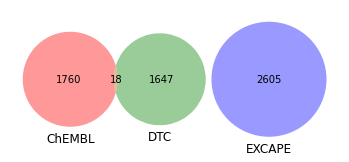

In [82]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc_ic50.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists

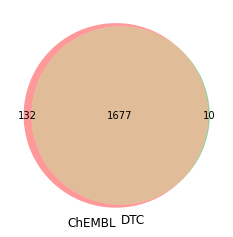

In [83]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc_ic50.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [84]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

1866
1778
1737


In [91]:
chembl[chembl.base_rdkit_smiles=='']

0

In [92]:
chembl=chembl.replace('',np.nan)
print(len(chembl[chembl.base_rdkit_smiles.isna()]))

32


In [61]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [94]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles


## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [93]:
dtc_ic50['base_rdkit_smiles'] = dtc_ic50.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(dtc_ic50.SMILES))
print(len(dtc_ic50.SMILES.unique()))
print(len(dtc_ic50.base_rdkit_smiles.unique()))

1855
1665
1623


In [95]:
dtc_ic50[dtc_ic50.base_rdkit_smiles=='']

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
417,CHEMBL1200431,P28223,GADOPENTETATE DIMEGLUMINE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7333529,DTCC00678414,1544899,46191,NaN,NaN,
419,CHEMBL1200528,P28223,CHROMIC CHLORIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7338988,DTCC00678493,1447878,46191,NaN,NaN,
445,CHEMBL1200693,P28223,MANGANESE CHLORIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7436148,DTCC00678623,671789,46191,NaN,NaN,
495,CHEMBL1201469,P28223,GRAMICIDIN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7329640,DTCC00679278,217579,46191,NaN,NaN,
497,CHEMBL1201631,P28223,INSULIN HUMAN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7435250,DTCC00679306,1798411,46191,NaN,NaN,
941,CHEMBL136478,P28223,SODIUM NITROPRUSSIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7462665,DTCC00320064,1155687,46191,NaN,NaN,
945,CHEMBL1366,P28223,AURANOFIN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7275120,DTCC00388917,833156,46191,NaN,NaN,
974,CHEMBL1386,P28223,TRANSPLATIN,NaN,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Na

In [96]:
dtc_ic50=dtc_ic50.replace('',np.nan)
dtc_ic50[dtc_ic50.base_rdkit_smiles.isna()]

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
417,CHEMBL1200431,P28223,GADOPENTETATE DIMEGLUMINE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7333529,DTCC00678414,1544899,46191,NaN,NaN,NaN
419,CHEMBL1200528,P28223,CHROMIC CHLORIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7338988,DTCC00678493,1447878,46191,NaN,NaN,NaN
445,CHEMBL1200693,P28223,MANGANESE CHLORIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7436148,DTCC00678623,671789,46191,NaN,NaN,NaN
495,CHEMBL1201469,P28223,GRAMICIDIN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7329640,DTCC00679278,217579,46191,NaN,NaN,NaN
497,CHEMBL1201631,P28223,INSULIN HUMAN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7435250,DTCC00679306,1798411,46191,NaN,NaN,NaN
941,CHEMBL136478,P28223,SODIUM NITROPRUSSIDE,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7462665,DTCC00320064,1155687,46191,NaN,NaN,NaN
945,CHEMBL1366,P28223,AURANOFIN,NaN,4,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774690.0,DTCT0023186,7275120,DTCC00388917,833156,46191,NaN,NaN,NaN
974,CHEMBL1386,P28223,TRANSPLATIN,NaN,0,SEROTONIN 2A (5-HT2A) RECEPTOR,HTR2A,GPCR,NaN,NaN,Na

In [97]:
dtc_ic50=dtc_ic50[~dtc_ic50.base_rdkit_smiles.isna()]

In [98]:
# Standardizting excape dataset
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

2605
2605
2604


In [99]:
excape[excape.base_rdkit_smiles=='']

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
2413,IMJRZBMLOMZHOP-KZZHAKJCNA-N,44427824,3356,A,6.97881,pubchem,297340,9606,HTR2A,2099,ClC1=C(N2CCN(O)(CC2)=C/C=C/CNC(=O)C=3C=CC(=CC3...,


In [100]:
excape=excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
2413,IMJRZBMLOMZHOP-KZZHAKJCNA-N,44427824,3356,A,6.97881,pubchem,297340,9606,HTR2A,2099,ClC1=C(N2CCN(O)(CC2)=C/C=C/CNC(=O)C=3C=CC(=CC3...,NaN


In [101]:
excape=excape[~excape.base_rdkit_smiles.isna()]

## **Curation step:** Save standardized datasets

In [103]:
#chembl.to_csv("HTR2A_ChEMBL_SMILES.csv")
#dtc_ic50.to_csv("HTR2A_DTC_SMILES.csv")
#excape.to_csv("HTR2A_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

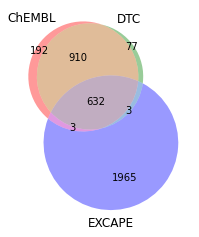

In [104]:
venn3([set(chembl.base_rdkit_smiles),
           set(dtc_ic50.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

## EDA: Examine compound diversity

In [108]:
from rdkit import Chem
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp

from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists
sns.set_context('poster')

In [109]:
sns.set_context('poster')
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

TypeError: ignored

In [15]:
dp.diversity_plots(dset_key='https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_ChEMBL_SMILES.csv',
                   datastore=False, 
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pChEMBL_Value')

NameError: ignored

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

array([1.        , 0.95238095, 0.91666667, ..., 0.1       , 0.8902439 ,
       0.81944444])

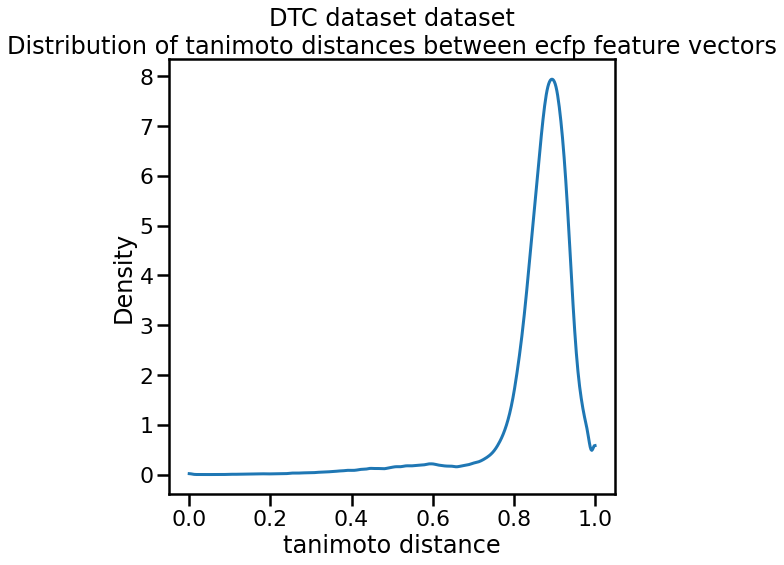

In [110]:
plot_tani_dist_distr(dtc_ic50, 'base_rdkit_smiles', 'DTC dataset') # check for NA or other types

In [112]:
dtc_ic50[['Compound_ID','base_rdkit_smiles','pDTC_Value']]

,Compound_ID,base_rdkit_smiles,pDTC_Value
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,NaN
3,CHEMBL1006,NCCCNCCSP(=O)(O)O,NaN
5,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,NaN
7,CHEMBL101,CCCCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O,NaN
12,CHEMBL101168,Nn1nnc2ccccc21,NaN
...,...,...,...
9421,NaN,C=CCNC(=O)/C=C/c1cc(OC)c(OC)c(OC)c1,5.000000
9422,NaN,CCCCNC(=O)/C=C/c1cc(OC)c(OC)c(OC)c1,5.000000
9429,NaN,CS(=O)(=O)c1ccc(-c2cnc(NCc3ccco3)n3cnnc23)cc1,4.522879
9452,NaN,COc1cccc(C(O)C2CCN(CCc3ccc(F)cc3)CC2)c1OC,8.958607


In [119]:
dp.diversity_plots('HTR2A_DTC_SMILES.csv',
                   datastore=False, 
                   id_col ='Compound_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pDTC_Value')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


AttributeError: ignored

In [118]:
!pip install pyopengl
!pip install cachetools
!pip install umap-learn

  Using cached https://files.pythonhosted.org/packages/54/25/2b4015e2b0c3be2efa6870cf2cf2bd969dd0e5f937476fc13c102209df32/llvmlite-0.36.0-cp37-cp37m-manylinux2010_x86_64.whl
  Found existing installation: llvmlite 0.29.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?